<a href="https://colab.research.google.com/github/sirfindcent/food-vision/blob/main/Notebooks/02_food_vision_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. 🍔👁 Food Vision Fine Tuning

In the previous notebook, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Since the experiment before works pretty good, now we're going to try another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For **feature extraction** transfer learning, you may only train the **top 1-3 layers** of a pre-trained model with your own data, in **fine-tuning** transfer learning, you might train **1-3+ layers** of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*


## What we're going to cover

We're going to go through the following with TensorFlow:

- Download and prepare the smaller dataset.
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Create the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

In [ ]:
# Check if we're using GPU
!nvidia-smi

Mon Sep 11 12:31:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating a helper function

In previous notebook we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So it's a good idea to put functions you'll want to use again in the script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used on previously here:https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Download the helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-11 12:31:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-11 12:31:11 (92.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import the helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab. when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only **10% of the training data** using **transfer learning** with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the **in-built pretrained models** within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to **fine-tune them** to our own custom dataset.

We'll also practice using **a new but similar dataloader function** to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) which is part of the [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils) module.

Finally, we'll also be using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. **The Functional API** is a more **flexible** way to create models than the **tf.keras.Sequential API.**

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [ ]:
# Get 10% percent of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-11 12:31:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   304MB/s    in 0.5s    

2023-09-11 12:31:15 (304 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdiretory
import os

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [ ]:
# Creating traning and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Preprocess our data and turn it into BatchDataset using image_dataset_from_directory
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                               image_size=IMG_SIZE,
                                                               label_mode="categorical",
                                                               batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check the training data datatype
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1): #take of 1 batch (32 img array and 32 one hot labels)
  print(images, labels)

tf.Tensor(
[[[[190.30103    149.0153      77.85715   ]
   [193.03061    147.81122     73.744896  ]
   [196.87245    149.44388     71.38265   ]
   ...
   [182.53024    175.24962    169.38747   ]
   [133.06625    127.18363    128.0459    ]
   [143.80136    140.75545    147.18408   ]]

  [[198.80612    152.80612     68.30612   ]
   [197.93367    151.87245     67.22449   ]
   [198.08673    151.0153      69.41327   ]
   ...
   [211.64267    204.5151     188.55597   ]
   [179.51505    175.71408    165.28555   ]
   [151.07668    150.7196     146.12267   ]]

  [[200.29082    153.93367     74.29082   ]
   [195.17346    150.35715     74.17347   ]
   [191.85205    151.82654     81.46939   ]
   ...
   [212.32141    204.5357     180.89285   ]
   [202.26006    198.94885    179.95909   ]
   [168.62201    170.05573    155.55061   ]]

  ...

  [[ 18.28073     20.28073     19.28073   ]
   [  9.04084     11.04084     10.04084   ]
   [  5.6939087    7.6939087    6.6939087 ]
   ...
   [  8.550974     6.979

### Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalize input (you don't have to for EfficientNets)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)(inputs)

# 5. Pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the models
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent")])


16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230911-123124
Epoch 1/5
24/24 [==============================] - 19s 254ms/step - loss: 1.8546 - accuracy: 0.4453 - val_loss: 1.3025 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 4s 134ms/step - loss: 1.0726 - accuracy: 0.7493 - val_loss: 0.8536 - val_accuracy: 0.8355
Epoch 3/5
24/24 [==============================] - 4s 137ms/step - loss: 0.7848 - accuracy: 0.8200 - val_loss: 0.7023 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 5s 192ms/step - loss: 0.6389 - accuracy: 0.8627 - val_loss: 0.6149 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 4s 136ms/step - loss: 0.5363 - accuracy: 0.8813 - val_loss: 0.5659 - val_accuracy: 0.8569


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.5600 - accuracy: 0.8556


[0.5599839687347412, 0.8555999994277954]

In [ ]:
# Check layers in our base model
for layers_number, layer in enumerate(base_model.layers):
  print(layers_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

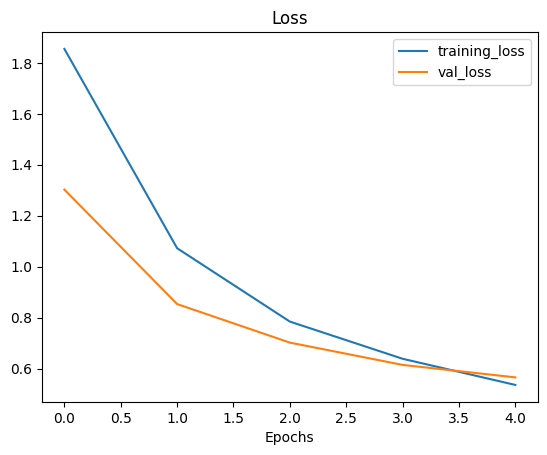

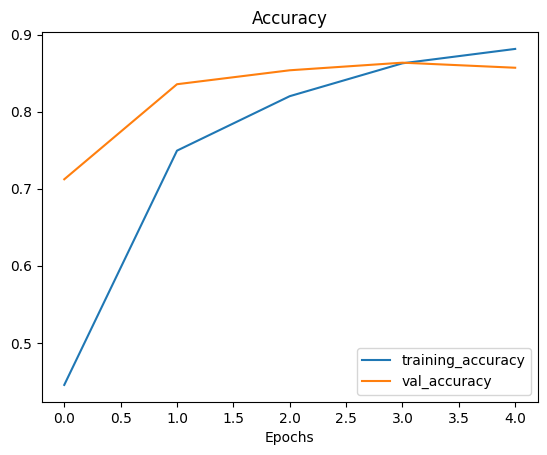

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape `(None, 7, 7, 1280)`...

But then **when it passes through** `GlobalAveragePooling2D`, it turns into `(None, 1280)`.
Let's use a similar shaped tensor of `(1,4,4,3)` and then pass it to `GlobalAveragePooling2D`.


In [ ]:
# Define the input shape
input_shape = (1, 2, 2, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through the global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[-0.4701874   0.3876027  -2.4585576 ]
   [-0.570602   -0.27473444 -1.4085737 ]]

  [[ 1.7479533   0.52780765 -0.1680999 ]
   [ 0.1188127  -0.04667766 -0.23145267]]]]

2D global average pooled random tensor:
 [[ 0.20649415  0.14849956 -1.0666709 ]]

Shape of input tensor: (1, 2, 2, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2]) # reduce the `input_tensor` shape at 1,2 axis/index and take the average

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.20649415,  0.14849956, -1.0666709 ]], dtype=float32)>

🔑**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is **pretrained model outputs a feature vector** (a long tensor of numbers which represent the learned representation of the model on a particular example, in our case, this it the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can **then be used to extract patterns** out of for our own specific problems.

## Running a series of transfer learning experiments

We've seen the incridible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we setup a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** Throughout all experiment the same test datasets will be used to evaluate our model... this ensures consistency across evaluation metrics.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-09-11 12:32:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   203MB/s    in 0.6s    

2023-09-11 12:32:15 (203 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# How many images are we working with?
import os

# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) method.

In [ ]:
# Setup data loaders
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) #default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the **different parameters** of the `ImageDataGenerator` class to **augment** our training images, this time we're going to build **data augmentation right into the model.**

How?

Using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating **a dedicated data augmentation layer** in a sequential model.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) **happens on the GPU** rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation **only happens during training**, so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

To use data augmentation right within our model we'll create **a Keras Sequential model consisting of only data preprocessing layers**, we can then use this **Sequential model within another Functional model.**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

**Visualize our data augmentation layer (and see what happens to our data)**

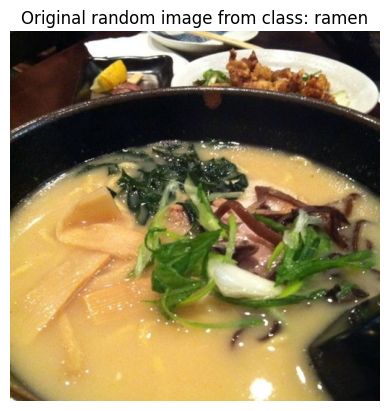

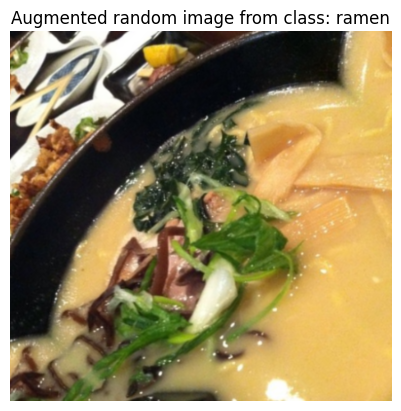

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base models layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output feature of base model (condese it /reduce dimensionality  into feature vector)
x = layers.GlobalAveragePooling2D()(x) # Whole model = passing inside , layers = passing at right side

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)), # 25% of test data to speed up the training
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name="1_percent_data_aug")]
                                )

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230911-123220
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3611 - accuracy: 0.1286 - val_loss: 2.2343 - val_accuracy: 0.1891
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1193 - accuracy: 0.3000 - val_loss: 2.0916 - val_accuracy: 0.2895
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8762 - accuracy: 0.5286 - val_loss: 1.9715 - val_accuracy: 0.3717
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7089 - accuracy: 0.6429 - val_loss: 1.8483 - val_accuracy: 0.4507
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5497 - accuracy: 0.7000 - val_loss: 1.7481 - val_accuracy: 0.5099


Wow!

How cool is that? Using only **7 training images per class**, using transfer learning our model was able to **get ~45%+ accuracy** on the validation set.

This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved **50.67% accuracy with all the data**, namely, **750 training images per class** (**note:** this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [ ]:
# Evaluate on full test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 65ms/step - loss: 1.7701 - accuracy: 0.4852


[1.7701109647750854, 0.4851999878883362]

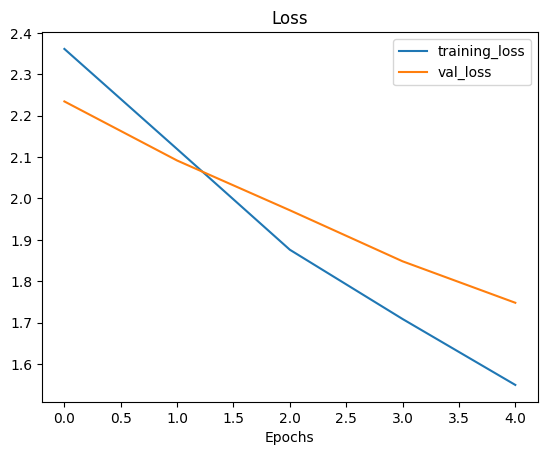

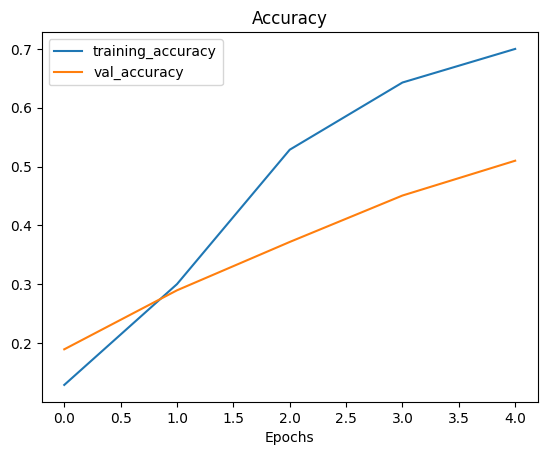

In [ ]:
# How do the model with 1% of the data and data augmentation model loss curves look?
plot_loss_curves(history_1)

## Model 2 : Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

In [ ]:
# Uncomment if you don't have the data
# # Get 10% of our data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# # Unzip the file
# unzip("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [ ]:
# Preprocess our data
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_10_percent,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build our data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1/255.) # no need of our EfficientNet because it has rescaling built in  , but other model might neeed like ResNetV2
], name="data_augmentation")

# Setup the input for model two
input_shape = (224,224,3)

# Create a frozen base model (backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # False bcz we want to add our own top layer (output layer)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer" )
x = data_augmentation(inputs, training=False) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # False bcz we want to keep the batchnorm layer frozen even after we unfreeze the base model (inference mode)
x = layers.GlobalAveragePooling2D()(x) # condensed the data into feature vector
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



To save time for later (when we want to perform multiple experiments with `model_2`), let's put the code above into a function we can resuse.

In [ ]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
model_2 = create_base_model()

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usefull so we can come and start where we left off  

In [ ]:
# Set the checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoints.ckpt"

# Create the model checkpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=False,
                                                        save_freq="epoch", # save every epoch
                                                        verbose=1)


**Fitting the model 2 with the ModelCheckpoint callback**

In [ ]:
initial_epochs = 5
# Fit the model saving checkpoints every epoch
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_aug/20230911-123305
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9625 - accuracy: 0.3640
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 22s 648ms/step - loss: 1.9625 - accuracy: 0.3640 - val_loss: 1.4155 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3164 - accuracy: 0.6840
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 13s 541ms/step - loss: 1.3164 - accuracy: 0.6840 - val_loss: 0.9711 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0027 - accuracy: 0.7813
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 12s 467ms/step - loss: 1.0027 - accuracy: 0.7813 - val_loss: 0.7558 - val_accuracy: 0.8421
Epo

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6187 - accuracy: 0.8476


[0.618665874004364, 0.847599983215332]

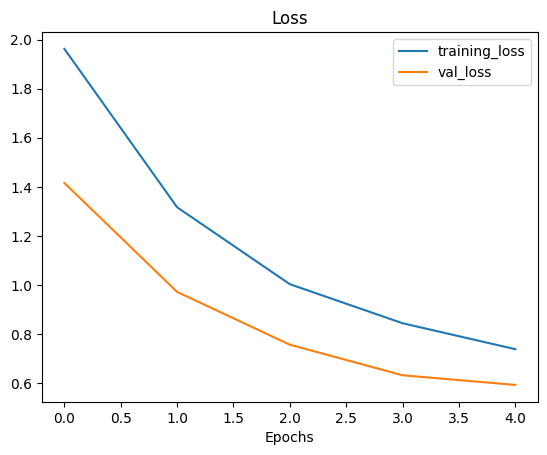

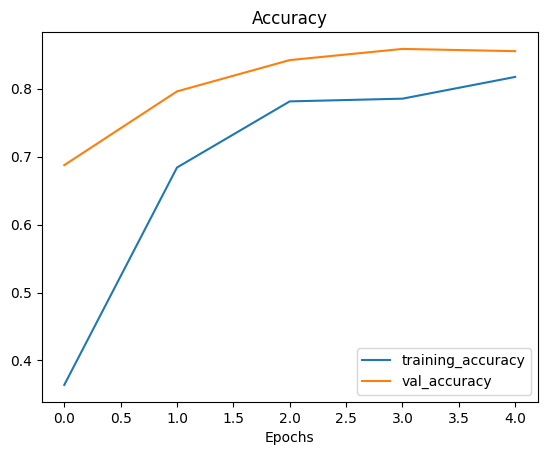

In [ ]:
# Plot the model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with **10% of the data** and data augmentation isn't as good as the model with **10% of the data without data augmentation** (see `model_0` results above), however the curves are **trending in the right direction**, meaning if we decided to **train for longer,** its metrics would likely **improve**.

**Loading in checkpointed weights**

Loading in checkpoints weight returns a model at a specific checkpoints.

In [ ]:
# Load in saved model weights and overwrite the existing weight with the loaded weight
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6187 - accuracy: 0.8476


In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the differences between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:**
- Fine-tuning usually works best *after* training **a feature extraction model for a few epochs** and with large amounts of data.
- **Unfreezed layer** means that the pattern in the layer is going to be **updated** during training.
- It is a good practice to **unfreeze the layer close to the top** of the model because the lower means the more the layer learned the **larger/general features** like the **roundness of pizza** instead of the specifc toppings.



We've verified our loaded model's performance, let's check out its layers.

In [ ]:
# Layers in loaded model
model_2.layers

How about we check their names, numbers and if they're trainable?

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7abb54236290> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7abb543cc7f0> | Trainable? True
Layer number: 2 | Layer name: efficientnetb0 | Layer type: <keras.src.engine.functional.Functional object at 0x7abb54277340> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7abb5b012560> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7abb54237880> | Trainable? True


Looking good.

We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetV2B0), a pooling layer and a Dense layer (the output layer).

How about a summary?

In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

Alright, it looks like all of the layers in the `efficientnetv2-b0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

> **Note:** The layers of `base_model` (our `efficientnetv2-b0` feature extractor) of `model_2` is accessible by referencing `model_2.layers[2]`.

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetb0'

In [ ]:
# How many layers are trainable in our model_2_base_model?
print(len(model_2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)

0


We can even check layer by layer to see if the they're trainable.

To access the layers in `model_2_base_model`, we can use the `layers` attribute.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_7 False
2 normalization_3 False
3 rescaling_8 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model everytime we make a change)
# recompile simply is going back through base model and see that we've adjusted some layer to be trainable and it recognize that
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),# when fine-tuning you typically want to lower the learning rate
                metrics=["accuracy"])

🔑 **Note:** When using fine-tuning, it's best practice to lower your learning rate by some amount, as we dont want to the unfreezed layers **overupdate** their pattern that can cause **overfitting.** The good rule of thumb is at least 10x .

Wonderful, now let's check which layers of the pretrained model are trainable.

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_7 False
2 normalization_3 False
3 rescaling_8 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Nice! It seems all layers except for the **last 10 are frozen and untrainable.**

Every time you **make a change** to your models, you need to **recompile** them.



How many trainable variables do we have now?

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainbale variables are there?
print(len(model_2.layers[2].trainable_variables))

0


Wonderful, it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another five epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230911-123453
Epoch 5/10
24/24 [==============================] - 20s 491ms/step - loss: 0.6848 - accuracy: 0.8400 - val_loss: 0.5965 - val_accuracy: 0.8536
Epoch 6/10
24/24 [==============================] - 9s 357ms/step - loss: 0.6529 - accuracy: 0.8493 - val_loss: 0.5803 - val_accuracy: 0.8503
Epoch 7/10
24/24 [==============================] - 11s 432ms/step - loss: 0.6591 - accuracy: 0.8320 - val_loss: 0.5689 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 10s 416ms/step - loss: 0.6610 - accuracy: 0.8373 - val_loss: 0.5830 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 10s 376ms/step - loss: 0.6462 - accuracy: 0.8333 - val_loss: 0.5551 - val_accuracy: 0.8569
Epoch 10/10
24/24 [==============================] - 9s 360ms/step - loss: 0.6237 - accuracy: 0.8547 - val_loss: 0.5445 - val_accuracy: 0.8668


> 🔑 **Note:** Fine-tuning usually takes far longer per epoch than feature extraction (due to updating more weights throughout a network).

Ho ho, looks like our model has gained a few percentage points of accuracy! Let's evalaute it.

In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5814 - accuracy: 0.8512


Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [ ]:
# Let's create a function to compare training history
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compare two TensorFlow History objects.
  """

  # Get the original history meausurement
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning") # reshift plot around epoch/plot a border line between feature extraction loss curves with fine tune one
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("epoch")
  plt.show()

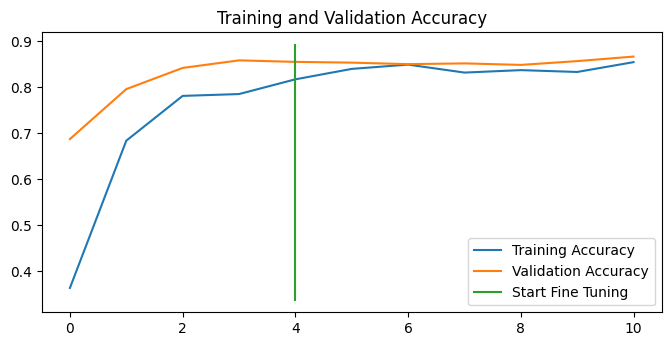

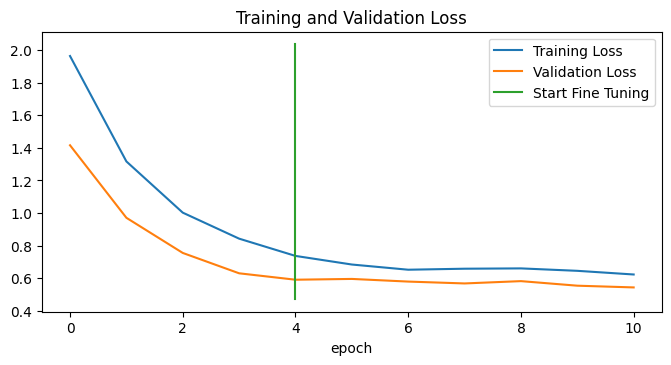

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model on all of the data
Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.


In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train"
test_dir_all_data = "10_food_classes_all_data/test"

--2023-09-11 12:36:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  48.8MB/s    in 9.7s    

2023-09-11 12:36:32 (50.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# How many images are we working with now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                     label_mode="categorical",
                                                                     image_size=IMG_SIZE,
                                                                     )

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Oh this is looking good. We've got 10x more images in of the training classes to work with.

The **test dataset is the same** we've been using for our previous experiments.

As it is now, our `model_2` has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current `model_2`.

In [ ]:
# Evaluate model 2 (this is the fine tuned version on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5814 - accuracy: 0.8512


[0.5813652276992798, 0.8511999845504761]

These are the same values as `results_fine_tune_10_percent`.

In [ ]:
results_fine_tune_10_percent

[0.5813652276992798, 0.8511999845504761]

To keep our experiments clean, we'll load a create a new instance of `model_2` using our `create_base_model()` function.

More specifically, we're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of `model_2`.

In [ ]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

And now to make sure it starts at the same checkpoint, we can load the checkpointed weights from `checkpoint_path`.

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

Let's now get a summary and check how many trainable variables there are.

In [ ]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
print(len(model_2.trainable_variables))

2


Nice! This is the same as our original checkpoint.

And the results should be the same as `results_10_percent_data_aug`.

In [ ]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 10s 83ms/step - loss: 0.6187 - accuracy: 0.8476


[0.6186659932136536, 0.847599983215332]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint` (**Model 2**).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (**Model 3**).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (**Model 4**).

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layer are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_layer True
4 output_layer True


Remember, the `base_model` of `model_2` (`efficientnetv2-b0`) can be referenced by `model_2.layers[2]`.

So let's unfreeze the last 10 layers of the `base_model` to make them trainable (for fine-tuning).

In [ ]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

Now let's make sure the right layers are trainable (we only want the last 10 to be trainable).

> **Note:** You could experiment which number of layers should be trainable here. Generally, the more data you have, the more layers that can be fine-tuned.

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_9 False
2 normalization_4 False
3 rescaling_10 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

Looking good! The last 10 layers are trainable (unfrozen).

We've got one more step to do before we can begin fine-tuning.

Do you remember what it is?

I'll give you a hint. We just reloaded the weights to our model and what do we need to do every time we make a change to our models?

Recompile them!


In [ ]:
# Recompile our model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230911-123710
Epoch 5/10
235/235 [==============================] - 82s 299ms/step - loss: 0.6514 - accuracy: 0.7901 - val_loss: 0.3227 - val_accuracy: 0.9046
Epoch 6/10
235/235 [==============================] - 60s 254ms/step - loss: 0.5190 - accuracy: 0.8288 - val_loss: 0.3047 - val_accuracy: 0.9046
Epoch 7/10
235/235 [==============================] - 52s 219ms/step - loss: 0.4616 - accuracy: 0.8504 - val_loss: 0.2635 - val_accuracy: 0.9112
Epoch 8/10
235/235 [==============================] - 52s 217ms/step - loss: 0.4136 - accuracy: 0.8649 - val_loss: 0.2504 - val_accuracy: 0.9178
Epoch 9/10
235/235 [==============================] - 48s 201ms/step - loss: 0.3748 - accuracy: 0.8825 - val_loss: 0.2461 - val_accuracy: 0.9178
Epoch 10/10
235/235 [==============================] - 45s 188ms/step - loss: 0.3542 - accuracy: 0.8859 - val_loss: 0.2417 - val_accuracy: 0.9178


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 72ms/step - loss: 0.2657 - accuracy: 0.9160


[0.2657027244567871, 0.9160000085830688]

In [ ]:
results_fine_tune_10_percent

[0.5813652276992798, 0.8511999845504761]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

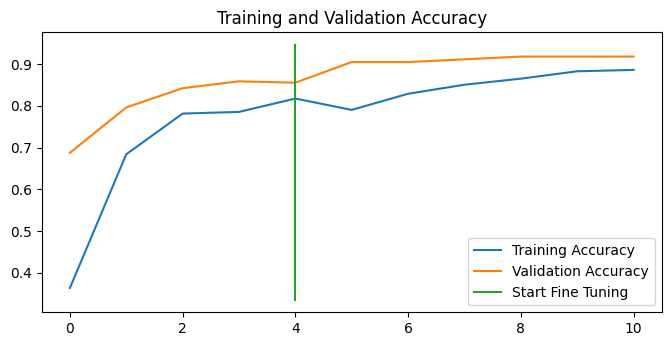

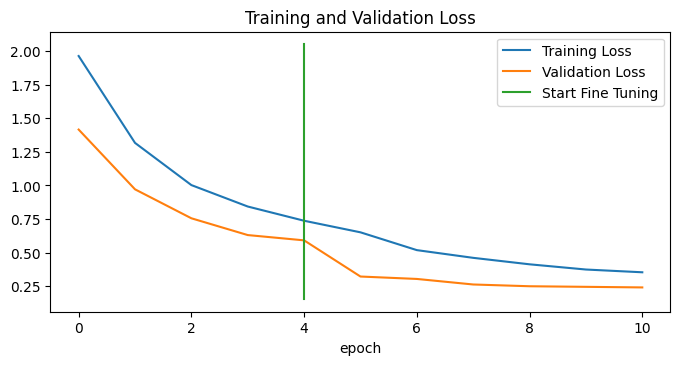

In [ ]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard
Right now our experimental results are **scattered all** throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`. We've been **tracking** our modelling experiments the whole time, and we can put all of them **together in one tensorboard.**

>🔑**Note:** Anything you upload to TensorBoard is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 models)
# Upload TensorBoard dev record
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amount of data and fine-tuning" \
  --one_shot # exits the uploader once it finished uploading

2023-09-11 12:42:58.299297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   SHL-VBP-HTK



New experiment created. View your TensorBoard at: https://tensorboard.dev/

Check the tensorboard here: https://tensorboard.dev/experiment/9BHkdXVnQFeKNhJRuEJUkw/